<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/main/notebooks/dataset_final_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generación de dataset completo con variables artificiales

Este notebook genera un dataset completo para modelos de predicción de precipitación que incluye:
- Variables de precipitación (CHIRPS)
- Variables topográficas (DEM)
- Transformaciones temporales (seno/coseno de meses y día del año)

Se utilizan técnicas de gestión de memoria para evitar problemas con el kernel.

Este notebook es compatible tanto con entornos locales como con Google Colab.

## Configuración del Entorno

Primero detectamos si estamos ejecutando en Google Colab o en un entorno local para configurar adecuadamente las rutas y dependencias.

In [32]:
# Detectar si estamos en Google Colab o en entorno local
import sys
import os
import subprocess

# Función para instalar paquetes
def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Función especial para instalar richdem en Colab
def install_richdem_colab():
    print("Instalando richdem manualmente en Colab...")
    !apt-get update
    !apt-get install -y build-essential cmake libgdal-dev
    !pip install pybind11
    !git clone --recursive https://github.com/r-barnes/richdem.git
    %cd richdem/wrappers/pyRichDEM/
    !pip install .
    %cd /content
    print("✅ richdem instalado correctamente.")

# Verificar si estamos en Colab
IN_COLAB = 'google.colab' in sys.modules

# Configuración según el entorno
if IN_COLAB:
    print("Ejecutando en Google Colab. Configurando entorno...")

    # Instalar paquetes normales
    required_packages = ['matplotlib', 'xarray', 'dask', 'netCDF4', 'psutil']
    for package in required_packages:
        try:
            __import__(package)
            print(f"✓ {package} ya está instalado")
        except ImportError:
            print(f"Instalando {package}...")
            install_package(package)

    # Instalar richdem aparte porque requiere compilación manual
    try:
        import richdem
        print("✓ richdem ya está instalado")
    except ImportError:
        install_richdem_colab()

    # Montar Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Definir rutas base
    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'

    # Crear carpetas necesarias si no existen
    for folder in ['data/output', 'models']:
        os.makedirs(os.path.join(BASE_PATH, folder), exist_ok=True)

    print(f"Base path configurado a: {BASE_PATH}")
    print("Entorno de Colab configurado correctamente.")

else:
    print("Ejecutando en entorno local.")
    BASE_PATH = '..'

    try:
        import richdem
        import xarray as xr
        import matplotlib.pyplot as plt
        import psutil

        print("✅ ¡RichDEM y demás librerías instaladas correctamente!")

    except ImportError as e:
        print(f"Advertencia: {e}")
        print("Algunas dependencias podrían faltar. Instálalas con pip o conda.")

print(f"Configuración completada. BASE_PATH = {BASE_PATH}")

Ejecutando en Google Colab. Configurando entorno...
✓ matplotlib ya está instalado
✓ xarray ya está instalado
✓ dask ya está instalado
✓ netCDF4 ya está instalado
✓ psutil ya está instalado
✓ richdem ya está instalado
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base path configurado a: /content/drive/MyDrive/ml_precipitation_prediction
Entorno de Colab configurado correctamente.
Configuración completada. BASE_PATH = /content/drive/MyDrive/ml_precipitation_prediction


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Importaciones necesarias
import numpy as np
import pandas as pd
import xarray as xr
import richdem as rd
import gc
import psutil
import os
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

# Configurar xarray para trabajar con dask para procesamiento paralelo
import dask
from dask.diagnostics import ProgressBar

# Suprimir advertencias
warnings.filterwarnings('ignore')

# Configuración de visualización
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [35]:
# Función para verificar el uso de memoria
def check_memory_usage():
    """Muestra el uso actual de memoria y sugiere posibles acciones."""
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()

    # Convertir a MB para mejor legibilidad
    memory_usage_mb = memory_info.rss / 1024 / 1024
    virtual_memory = psutil.virtual_memory()
    available_mb = virtual_memory.available / 1024 / 1024
    total_mb = virtual_memory.total / 1024 / 1024
    used_percentage = virtual_memory.percent

    print(f"\n--- Uso de Memoria ---")
    print(f"Memoria usada por este proceso: {memory_usage_mb:.1f} MB")
    print(f"Memoria total disponible: {available_mb:.1f} MB de {total_mb:.1f} MB ({used_percentage:.1f}%)")

    # Sugerir acciones basadas en el uso de memoria
    if used_percentage > 85:
        print("ADVERTENCIA: Uso de memoria crítico! Se recomienda:")
        print("  - Liberar variables innecesarias (use 'del variable')")
        print("  - Ejecutar gc.collect() para liberar memoria")
        print("  - Reducir el tamaño de los chunks")
        print("  - Guardar resultados intermedios y reiniciar el kernel")
    elif used_percentage > 70:
        print("ATENCIÓN: Uso de memoria elevado. Considere liberar variables no utilizadas.")
    else:
        print("Uso de memoria normal.")

    return memory_usage_mb, available_mb, used_percentage

In [36]:
# Clase auxiliar para monitorear el progreso
class DatasetGenerator:
    """Clase auxiliar para generar y monitorear el dataset completo."""

    @staticmethod
    def monitor_computation(func):
        """Decorador para monitorear el progreso de computaciones."""
        def wrapper(*args, **kwargs):
            print(f"Iniciando: {func.__name__}")
            check_memory_usage()
            start_time = datetime.now()

            with ProgressBar():
                result = func(*args, **kwargs)

            end_time = datetime.now()
            duration = end_time - start_time
            print(f"Completado: {func.__name__} en {duration}")
            check_memory_usage()
            return result
        return wrapper

    @staticmethod
    def plot_sample(dataset, var_name, time_index=0):
        """Visualiza una muestra del dataset."""
        plt.figure(figsize=(10, 8))

        if 'time' in dataset[var_name].dims:
            # Variable con dimensión temporal
            data = dataset[var_name].isel(time=time_index)
            title = f"{var_name} - {pd.Timestamp(dataset.time.values[time_index]).strftime('%Y-%m-%d')}"
        else:
            # Variable sin dimensión temporal
            data = dataset[var_name]
            title = f"{var_name}"

        # Crear mapa de calor
        im = plt.imshow(data, cmap='viridis')
        plt.colorbar(im, label=var_name)
        plt.title(title)
        plt.xlabel('Longitud')
        plt.ylabel('Latitud')
        plt.grid(False)
        plt.show()

        # Mostrar estadísticas básicas
        stats = {
            'min': float(data.min().values),
            'max': float(data.max().values),
            'mean': float(data.mean().values),
            'std': float(data.std().values)
        }
        print(f"Estadísticas para {var_name}:")
        for k, v in stats.items():
            print(f"  {k}: {v:.4f}")

## 1. Cargar datos de precipitación y elevación

In [37]:
import os
import xarray as xr
import numpy as np
import psutil

# ---------------------------------------------------------------
# Configuración de CHUNK_SIZE dinámico basado en memoria disponible
# ---------------------------------------------------------------

def get_optimal_chunk_size():
    """Define el tamaño de chunks óptimo según la RAM disponible"""
    mem = psutil.virtual_memory()
    total_gb = mem.total / (1024 ** 3)  # Convertir bytes a GB
    print(f"🧠 Memoria total detectada: {total_gb:.2f} GB")

    if total_gb < 8:
        return {'time': 10, 'latitude': 50, 'longitude': 50}
    elif total_gb < 16:
        return {'time': 20, 'latitude': 100, 'longitude': 100}
    elif total_gb < 32:
        return {'time': 30, 'latitude': 200, 'longitude': 200}
    else:
        return {'time': 40, 'latitude': 300, 'longitude': 300}

# Asignar CHUNK_SIZE
CHUNK_SIZE = get_optimal_chunk_size()
print(f"🔧 Chunk size configurado: {CHUNK_SIZE}")

# ---------------------------------------------------------------
# Definición de rutas
# ---------------------------------------------------------------

# BASE_PATH debería estar definido previamente
chirps_path = os.path.join(BASE_PATH, 'data/output/boyaca_region_daily.nc')
dem_path = os.path.join(BASE_PATH, 'data/output/dem_boyaca_90.nc')

output_directory = os.path.join(BASE_PATH, 'data/output')
output_path = os.path.join(output_directory, 'complete_dataset_with_features.nc')

# Crear directorio de salida si no existe
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"📁 Directorio creado: {output_directory}")
else:
    print(f"📁 Directorio de salida existe: {output_directory}")

# Verificar existencia de archivos
for file_path in [chirps_path, dem_path]:
    if os.path.exists(file_path):
        print(f"✅ Archivo encontrado: {file_path}")
    else:
        print(f"⚠️ ADVERTENCIA: Archivo no encontrado: {file_path}")

# ---------------------------------------------------------------
# Función para imprimir estadísticas del dataset
# ---------------------------------------------------------------

def describe_dataset(ds, name="Dataset"):
    """Imprime resumen de un dataset xarray"""
    print(f"\n📄 Estadísticas de {name}:")
    print(f"- Dimensiones: {dict(ds.dims)}")

    # Estadísticas de coordenadas
    for coord in ['latitude', 'longitude']:
        if coord in ds.coords:
            coord_values = ds.coords[coord].values
            print(f"  ◦ {coord}: min={np.min(coord_values):.4f}, max={np.max(coord_values):.4f}, std={np.std(coord_values):.4f}")

    # Estadísticas de variables
    print(f"- Variables:")
    for var in ds.data_vars:
        data = ds[var].values
        if np.issubdtype(data.dtype, np.number):
            print(f"  • {var}: min={np.nanmin(data):.4f}, max={np.nanmax(data):.4f}, mean={np.nanmean(data):.4f}, std={np.nanstd(data):.4f}")
        else:
            print(f"  • {var}: tipo de dato {data.dtype}")

# ---------------------------------------------------------------
# Cargar los datasets aplicando los chunks
# ---------------------------------------------------------------

# Cargar CHIRPS
print("\n📥 Cargando dataset CHIRPS...")
chirps_ds = xr.open_dataset(chirps_path, chunks=CHUNK_SIZE)
describe_dataset(chirps_ds, "CHIRPS")

# Cargar DEM
print("\n📥 Cargando dataset DEM...")
dem_chunks = {k: v for k, v in CHUNK_SIZE.items() if k in ['latitude', 'longitude']}
dem_ds = xr.open_dataset(dem_path, chunks=dem_chunks)
describe_dataset(dem_ds, "DEM")


🧠 Memoria total detectada: 50.99 GB
🔧 Chunk size configurado: {'time': 40, 'latitude': 300, 'longitude': 300}
📁 Directorio de salida existe: /content/drive/MyDrive/ml_precipitation_prediction/data/output
✅ Archivo encontrado: /content/drive/MyDrive/ml_precipitation_prediction/data/output/boyaca_region_daily.nc
✅ Archivo encontrado: /content/drive/MyDrive/ml_precipitation_prediction/data/output/dem_boyaca_90.nc

📥 Cargando dataset CHIRPS...

📄 Estadísticas de CHIRPS:
- Dimensiones: {'time': 16130, 'latitude': 62, 'longitude': 66}
  ◦ latitude: min=4.3250, max=7.3750, std=0.8948
  ◦ longitude: min=-74.9750, max=-71.7250, std=0.9525
- Variables:
  • precip: min=0.0000, max=380.8983, mean=6.1375, std=11.3565

📥 Cargando dataset DEM...

📄 Estadísticas de DEM:
- Dimensiones: {'latitude': 4800, 'longitude': 7200}
  ◦ latitude: min=4.0013, max=8.0004, std=1.1547
  ◦ longitude: min=-76.0004, max=-70.0013, std=1.7321
- Variables:
  • DEM: min=18.0000, max=5327.0000, mean=961.1704, std=1048.0789


Iniciando generación del dataset completo...

--- Uso de Memoria ---
Memoria usada por este proceso: 1228.4 MB
Memoria total disponible: 49166.2 MB de 52216.5 MB (5.8%)
Uso de memoria normal.

1. Cargando datos con chunks...
CHIRPS cargado: FrozenMappingWarningOnValuesAccess({'time': 16130, 'latitude': 62, 'longitude': 66})

--- Uso de Memoria ---
Memoria usada por este proceso: 1228.4 MB
Memoria total disponible: 49156.7 MB de 52216.5 MB (5.9%)
Uso de memoria normal.
DEM cargado: FrozenMappingWarningOnValuesAccess({'latitude': 4800, 'longitude': 7200})

--- Uso de Memoria ---
Memoria usada por este proceso: 1228.4 MB
Memoria total disponible: 49161.3 MB de 52216.5 MB (5.9%)
Uso de memoria normal.

2. Identificando variable de precipitación en CHIRPS...
Variable encontrada: precip
Usando precip como variable de precipitación

3. Alineando coordenadas DEM con CHIRPS...
Interpolando DEM a la resolución de CHIRPS...
Interpolación completada.
Corrigiendo origen y alineación de coordenadas.

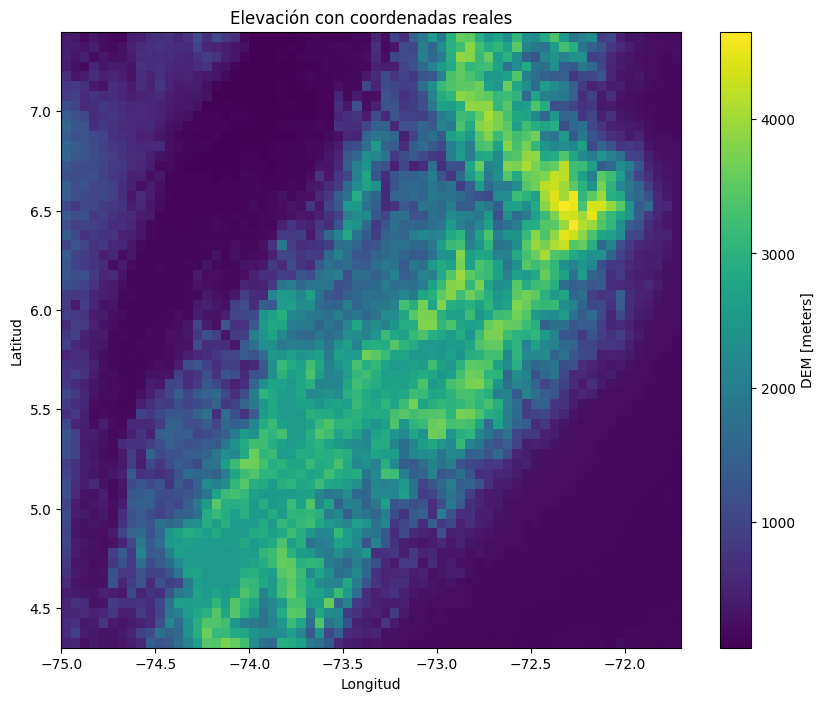


6. Calculando características topográficas usando RichDEM...
Preparando cálculo de pendiente y aspecto...
Calculando pendiente y aspecto usando gradientes...

--- Uso de Memoria ---
Memoria usada por este proceso: 1210.6 MB
Memoria total disponible: 49264.3 MB de 52216.5 MB (5.7%)
Uso de memoria normal.

7. Calculando estadísticas mensuales de precipitación...

8. Creando dataset final con todas las variables...
Agregando precipitación original...

--- Uso de Memoria ---
Memoria usada por este proceso: 1403.3 MB
Memoria total disponible: 49078.2 MB de 52216.5 MB (6.0%)
Uso de memoria normal.
Calculando total de precipitación mensual...
Procesando 530 meses únicos...
Procesando mes 1/530: 1981-01
Procesando mes 11/530: 1981-11
Procesando mes 21/530: 1982-09
Procesando mes 31/530: 1983-07
Procesando mes 41/530: 1984-05
Procesando mes 51/530: 1985-03
Procesando mes 61/530: 1986-01
Procesando mes 71/530: 1986-11
Procesando mes 81/530: 1987-09
Procesando mes 91/530: 1988-07
Procesando mes 

In [51]:
def compute_slope_aspect(elevation_array, cellsize=1):
    grad_y, grad_x = np.gradient(elevation_array, cellsize)
    slope = np.sqrt(grad_x**2 + grad_y**2)
    slope = np.arctan(slope) * (180/np.pi)
    aspect = np.arctan2(-grad_x, grad_y) * (180/np.pi)
    aspect = np.where(aspect < 0, 90.0 - aspect, 360.0 - aspect + 90.0)
    aspect = np.mod(aspect, 360.0)
    return slope, aspect


def generate_complete_dataset(chirps_path, dem_path, output_path, chunk_size=20):
    """
    Genera un dataset completo con variables artificiales de elevación, precipitación,
    y transformaciones temporales (seno/coseno de meses y año).
    Utiliza chunks y técnicas de gestión de memoria para prevenir fallos en el kernel.

    Parameters:
    -----------
    chirps_path : str
        Ruta al dataset CHIRPS
    dem_path : str
        Ruta al dataset DEM
    output_path : str
        Ruta donde se guardará el dataset final
    chunk_size : int
        Tamaño de los chunks para procesamiento
    """
    try:
        print("Iniciando generación del dataset completo...")
        check_memory_usage()

        # 1. Cargar datos con chunks para optimizar memoria
        print("\n1. Cargando datos con chunks...")
        chirps_chunks = {'latitude': chunk_size, 'longitude': chunk_size, 'time': -1}
        dem_chunks = {'latitude': chunk_size, 'longitude': chunk_size}

        chirps_ds = xr.open_dataset(chirps_path, chunks=chirps_chunks)
        print(f"CHIRPS cargado: {chirps_ds.dims}")
        check_memory_usage()

        dem_ds = xr.open_dataset(dem_path, chunks=dem_chunks)
        print(f"DEM cargado: {dem_ds.dims}")
        check_memory_usage()

        # 2. Identificar la variable de precipitación en CHIRPS
        print("\n2. Identificando variable de precipitación en CHIRPS...")
        precip_var = None
        for var_name in chirps_ds.data_vars:
            print(f"Variable encontrada: {var_name}")
            precip_var = var_name
            break

        if not precip_var:
            raise ValueError("No se encontró ninguna variable de datos en CHIRPS")

        print(f"Usando {precip_var} como variable de precipitación")

        # 3. Alinear coordenadas - interpolando DEM a la resolución de CHIRPS
        print("\n3. Alineando coordenadas DEM con CHIRPS...")

        # Verificar si las dimensiones no coinciden
        if dem_ds.sizes['longitude'] != chirps_ds.sizes['longitude'] or dem_ds.sizes['latitude'] != chirps_ds.sizes['latitude']:
            print("Interpolando DEM a la resolución de CHIRPS...")
            dem_ds = dem_ds.interp(
                longitude=chirps_ds.longitude,
                latitude=chirps_ds.latitude,
                method='linear',  # Interpolación bilineal
                kwargs={"fill_value": "extrapolate"}  # Evitar NaNs en bordes
            )
            print("Interpolación completada.")

        # Reasignar las coordenadas para garantizar origen y pasos iguales
        print("Corrigiendo origen y alineación de coordenadas...")
        dem_ds = dem_ds.assign_coords(
            longitude=chirps_ds.longitude,
            latitude=chirps_ds.latitude
        )
        print("Coordenadas de origen alineadas perfectamente.")

        check_memory_usage()

        # 4. Crear variables derivadas del tiempo (mes/año)
        print("\n4. Generando variables temporales (seno/coseno)...")

        # Extraer tiempo como dataframe para facilitar manipulación
        print("Extrayendo fechas del dataset...")
        times = pd.to_datetime(chirps_ds.time.values)
        months = times.month
        years = times.year
        days_in_year = 365.25

        # Crear variables cíclicas para mes (periodo = 12)
        print("Calculando seno/coseno de meses...")
        month_sin = np.sin(2 * np.pi * months / 12)
        month_cos = np.cos(2 * np.pi * months / 12)

        # Crear variables cíclicas para día del año (periodo = 365.25)
        print("Calculando seno/coseno del día del año...")
        day_of_year = times.dayofyear
        doy_sin = np.sin(2 * np.pi * day_of_year / days_in_year)
        doy_cos = np.cos(2 * np.pi * day_of_year / days_in_year)

        # 5. Extraer la variable de elevación del DEM
        print("\n5. Extrayendo variables de elevación del DEM...")
        # Correcto para mantener las coordenadas
        elevation = dem_ds[list(dem_ds.data_vars)[0]]

        import matplotlib.pyplot as plt
        # Graficar elevación con coordenadas reales
        plt.figure(figsize=(10, 8))
        elevation.plot(cmap='viridis')
        plt.title('Elevación con coordenadas reales')
        plt.xlabel('Longitud')
        plt.ylabel('Latitud')
        plt.show()

        # 6. Calcular variables topográficas usando RichDEM con manejo de memoria
        print("\n6. Calculando características topográficas usando RichDEM...")

        # Procesar por bloques para evitar problemas de memoria
        print("Preparando cálculo de pendiente y aspecto...")
        dem_data = elevation.values

        # Verificar si hay valores NaN y reemplazarlos con un valor NoData para richdem
        nan_mask = np.isnan(dem_data)
        if nan_mask.any():
            print(f"Encontrados {nan_mask.sum()} valores NaN en DEM, reemplazando con NoData")
            dem_data_clean = np.copy(dem_data)
            dem_data_clean[nan_mask] = -9999  # Valor NoData para richdem
        else:
            dem_data_clean = dem_data

        # Calcular pendiente (slope)
        # print("Calculando pendiente...")
        # dem_rd = rd.TerrainAttribute(dem_data_clean, attrib='slope_degrees', nodata=-9999)
        # dem_rd.geotransform = [0, 1, 0, 0, 0, -1]  # Transformación geoespacial simple
        # slope = rd.TerrainAttribute(dem_rd, attrib='slope_degrees')
        # Restaurar NaNs
        # slope = slope.astype(np.float32)
        # if nan_mask.any():
            # slope[nan_mask] = np.nan

        # Liberar memoria
        # del dem_rd
        # gc.collect()
        # check_memory_usage()

        # Calcular aspecto (aspect)
        # print("Calculando aspecto...")
        # aspect = rd.TerrainAttribute(dem_data_clean, attrib='aspect', nodata=-9999)
        # dem_rd.geotransform = [0, 1, 0, 0, 0, -1]
        # aspect = rd.TerrainAttribute(dem_rd, attrib='aspect')
        # Restaurar NaNs
        # aspect = aspect.astype(np.float32)
        # if nan_mask.any():
            # aspect[nan_mask] = np.nan

        # Liberar memoria
        # del dem_rd, dem_data_clean, nan_mask
        # gc.collect()
        # check_memory_usage()
        print("Calculando pendiente y aspecto usando gradientes...")
        slope, aspect = compute_slope_aspect(dem_data_clean)
        slope = slope.astype(np.float32)
        aspect = aspect.astype(np.float32)

        # Restaurar NaNs
        if np.isnan(dem_data).any():
            slope[np.isnan(dem_data)] = np.nan
            aspect[np.isnan(dem_data)] = np.nan

        gc.collect()
        check_memory_usage()

        # 7. Calcular variables mensuales de precipitación
        print("\n7. Calculando estadísticas mensuales de precipitación...")

        # Crear dataset con todas las variables derivadas
        print("\n8. Creando dataset final con todas las variables...")

        # Iniciar con un dataset vacío
        ds_final = xr.Dataset(
            coords={
                'time': chirps_ds.time,
                'latitude': chirps_ds.latitude,
                'longitude': chirps_ds.longitude
            }
        )

        # Agregar precipitación original
        print("Agregando precipitación original...")
        ds_final['precipitation'] = chirps_ds[precip_var]

        # Liberar memoria de chirps_ds si ya no se necesita
        chirps_data = chirps_ds[precip_var].values
        chirps_ds.close()
        del chirps_ds
        gc.collect()
        check_memory_usage()

        # Calcular estadísticas mensuales de precipitación
        print("Calculando total de precipitación mensual...")
        # Agrupar por año y mes
        dates_pd = pd.DataFrame({'time': times, 'month': months, 'year': years})
        unique_year_months = dates_pd.drop_duplicates(['year', 'month'])[['year', 'month']].values

        # Inicializar arrays para las estadísticas mensuales
        lat_dim = len(ds_final.latitude)
        lon_dim = len(ds_final.longitude)
        time_dim = len(unique_year_months)  # Número de meses únicos

        monthly_total = np.zeros((time_dim, lat_dim, lon_dim), dtype=np.float32)
        monthly_max = np.zeros((time_dim, lat_dim, lon_dim), dtype=np.float32)
        monthly_min = np.zeros((time_dim, lat_dim, lon_dim), dtype=np.float32)
        monthly_std = np.zeros((time_dim, lat_dim, lon_dim), dtype=np.float32)

        # Crear array para las fechas mensuales
        monthly_dates = []

        # Procesar mes por mes para evitar problemas de memoria
        print(f"Procesando {len(unique_year_months)} meses únicos...")
        for i, (year, month) in enumerate(unique_year_months):
            if i % 10 == 0:
                print(f"Procesando mes {i+1}/{len(unique_year_months)}: {year}-{month:02d}")

            # Filtrar fechas para este mes
            month_indices = np.where((years == year) & (months == month))[0]
            month_data = chirps_data[month_indices]

            # Calcular estadísticas
            monthly_total[i] = np.sum(month_data, axis=0)
            monthly_max[i] = np.max(month_data, axis=0)
            monthly_min[i] = np.min(month_data, axis=0)
            monthly_std[i] = np.std(month_data, axis=0)

            # Añadir fecha (primer día del mes)
            monthly_dates.append(np.datetime64(f"{year}-{month:02d}-01"))

        # Crear coordenada de tiempo mensual
        monthly_time = np.array(monthly_dates)

        # Liberar memoria
        del chirps_data
        gc.collect()
        check_memory_usage()

        # Añadir variables mensuales al dataset
        print("Agregando variables mensuales al dataset...")
        ds_monthly = xr.Dataset(
            data_vars={
                'total_precipitation': xr.DataArray(
                    monthly_total,
                    dims=['time', 'latitude', 'longitude'],
                    coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
                ),
                'max_daily_precipitation': xr.DataArray(
                    monthly_max,
                    dims=['time', 'latitude', 'longitude'],
                    coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
                ),
                'min_daily_precipitation': xr.DataArray(
                    monthly_min,
                    dims=['time', 'latitude', 'longitude'],
                    coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
                ),
                'daily_precipitation_std': xr.DataArray(
                    monthly_std,
                    dims=['time', 'latitude', 'longitude'],
                    coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
                )
            }
        )

        # Liberar memoria de arrays intermedios
        del monthly_total, monthly_max, monthly_min, monthly_std
        gc.collect()
        check_memory_usage()

        # Añadir variables cíclicas de tiempo
        print("Agregando variables cíclicas de tiempo...")

        # Extraer mes y año para las fechas mensuales
        monthly_dates_pd = pd.DatetimeIndex(monthly_time)
        monthly_month = monthly_dates_pd.month
        monthly_doy = monthly_dates_pd.dayofyear

        # Calcular seno y coseno para meses
        month_sin_monthly = np.sin(2 * np.pi * monthly_month / 12)
        month_cos_monthly = np.cos(2 * np.pi * monthly_month / 12)

        # Calcular seno y coseno para día del año
        doy_sin_monthly = np.sin(2 * np.pi * monthly_doy / days_in_year)
        doy_cos_monthly = np.cos(2 * np.pi * monthly_doy / days_in_year)

        # Crear arrays 3D usando numpy directamente en lugar de broadcast_to
        print("Creando arrays 3D para variables cíclicas...")
        time_size = len(monthly_time)

        # Inicializar arrays vacíos
        month_sin_3d = np.zeros((time_size, lat_dim, lon_dim), dtype=np.float32)
        month_cos_3d = np.zeros((time_size, lat_dim, lon_dim), dtype=np.float32)
        doy_sin_3d = np.zeros((time_size, lat_dim, lon_dim), dtype=np.float32)
        doy_cos_3d = np.zeros((time_size, lat_dim, lon_dim), dtype=np.float32)

        # Llenar los arrays manualmente para evitar problemas de memoria
        for t in range(time_size):
            # Asignar el mismo valor a toda la slice de tiempo
            month_sin_3d[t, :, :] = month_sin_monthly[t]
            month_cos_3d[t, :, :] = month_cos_monthly[t]
            doy_sin_3d[t, :, :] = doy_sin_monthly[t]
            doy_cos_3d[t, :, :] = doy_cos_monthly[t]

            # Liberar memoria cada cierto número de iteraciones
            if t > 0 and t % 50 == 0:
                gc.collect()
                print(f"Procesados {t}/{time_size} pasos de tiempo para variables cíclicas")

        # Crear DataArrays con los arrays 3D ya inicializados
        ds_monthly['month_sin'] = xr.DataArray(
            month_sin_3d,
            dims=['time', 'latitude', 'longitude'],
            coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
        )

        ds_monthly['month_cos'] = xr.DataArray(
            month_cos_3d,
            dims=['time', 'latitude', 'longitude'],
            coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
        )

        ds_monthly['doy_sin'] = xr.DataArray(
            doy_sin_3d,
            dims=['time', 'latitude', 'longitude'],
            coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
        )

        ds_monthly['doy_cos'] = xr.DataArray(
            doy_cos_3d,
            dims=['time', 'latitude', 'longitude'],
            coords={'time': monthly_time, 'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
        )

        # Liberar memoria de los arrays temporales
        del month_sin_monthly, month_cos_monthly, doy_sin_monthly, doy_cos_monthly
        del month_sin_3d, month_cos_3d, doy_sin_3d, doy_cos_3d
        gc.collect()
        check_memory_usage()

        # Añadir variables topográficas
        print("Agregando variables topográficas...")
        ds_topo = xr.Dataset(
            data_vars={
                'elevation': xr.DataArray(
                    elevation.values,
                    dims=['latitude', 'longitude'],
                    coords={'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
                ),
                'slope': xr.DataArray(
                    slope,
                    dims=['latitude', 'longitude'],
                    coords={'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
                ),
                'aspect': xr.DataArray(
                    aspect,
                    dims=['latitude', 'longitude'],
                    coords={'latitude': ds_final.latitude, 'longitude': ds_final.longitude}
                )
            }
        )

        # Liberar memoria
        del elevation, slope, aspect
        gc.collect()
        check_memory_usage()

        # Combinar datasets (mensual y topo)
        print("\n9. Combinando datasets...")
        final_combined = xr.merge([ds_monthly, ds_topo])

        # Añadir metadatos
        final_combined.attrs['description'] = 'ST-HyMOUNTAIN-Net ready dataset with CHIRPS monthly precipitation and DEM variables'
        final_combined.attrs['source'] = 'CHIRPS v2.0 & DEM Boyacá'
        final_combined.attrs['author'] = 'Your Name'
        final_combined.attrs['created_at'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        # Configurar chunks óptimos para el almacenamiento
        print("\n10. Configurando chunks para almacenamiento eficiente...")
        encoding = {var: {'zlib': True, 'complevel': 5} for var in final_combined.data_vars}

        # Guardar el dataset resultante
        print(f"\n11. Guardando dataset final en {output_path}...")
        final_combined.to_netcdf(
            output_path,
            encoding=encoding,
            compute=True  # Fuerza la computación ahora
        )

        print(f"\nDataset generado y guardado exitosamente en {output_path}")
        print("Dimensiones finales del dataset:")
        print(f"- Variables: {list(final_combined.data_vars)}")
        print(f"- Dimensiones: {dict(final_combined.dims)}")

        # Verificar uso final de memoria
        check_memory_usage()

        return final_combined

    except Exception as e:
        print(f"Error generando dataset completo: {e}")
        import traceback
        traceback.print_exc()
        return None
    finally:
        # Asegurarse de liberar toda la memoria
        gc.collect()
        check_memory_usage()

# Ejecutar la generación del dataset completo
# Ya definimos estas rutas arriba usando BASE_PATH
# chirps_path, dem_path y output_path ya están definidos

# Ejecutar con manejo de excepciones
try:
    complete_dataset = generate_complete_dataset(
        chirps_path=chirps_path,
        dem_path=dem_path,
        output_path=output_path,
        chunk_size=20  # Ajustar según las capacidades del sistema
    )

    if complete_dataset is not None:
        print("\nGeneración del dataset completada con éxito.")
        print("Para visualizar los resultados, cargue el dataset desde el archivo guardado.")
except Exception as e:
    print(f"Error ejecutando la generación del dataset: {e}")

## Visualización de Resultados

A continuación, cargamos el dataset generado y visualizamos algunas de las variables para verificar que todo se ha generado correctamente.

Dataset cargado exitosamente con 11 variables.
Variables disponibles: ['total_precipitation', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'elevation', 'slope', 'aspect']
Dimensiones: {'time': 530, 'latitude': 62, 'longitude': 66}

Visualizando variables:


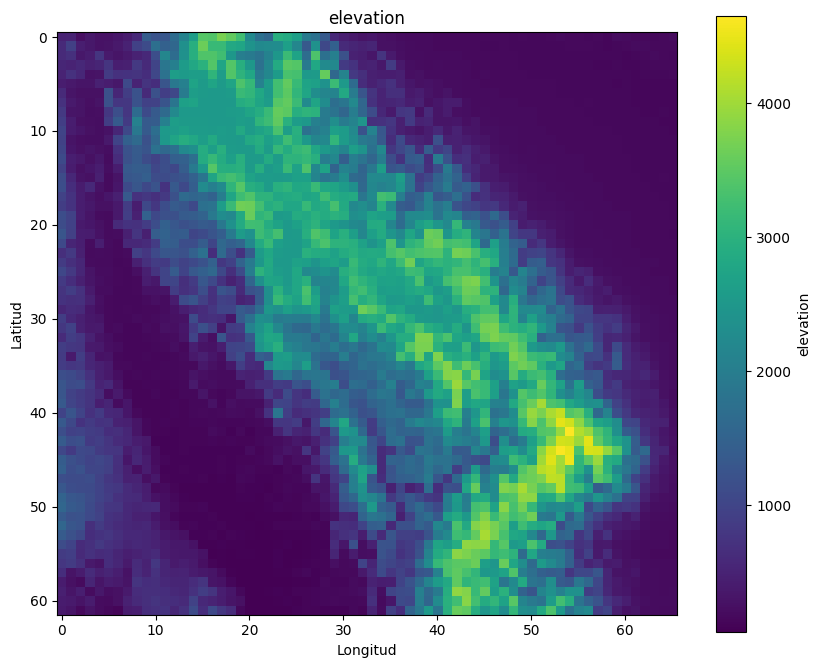

Estadísticas para elevation:
  min: 59.5000
  max: 4653.8011
  mean: 1274.7993
  std: 1131.7746


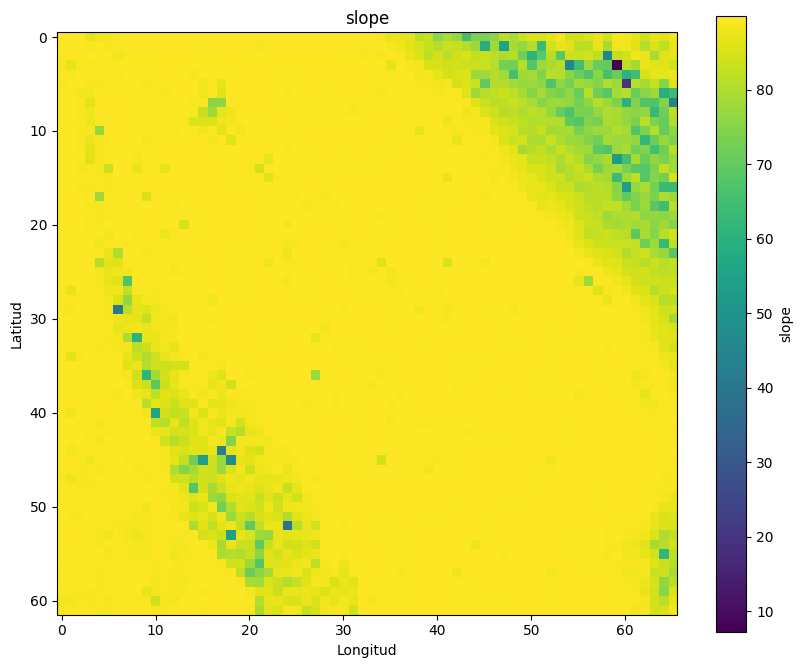

Estadísticas para slope:
  min: 7.2518
  max: 89.9560
  mean: 87.7482
  std: 5.0947


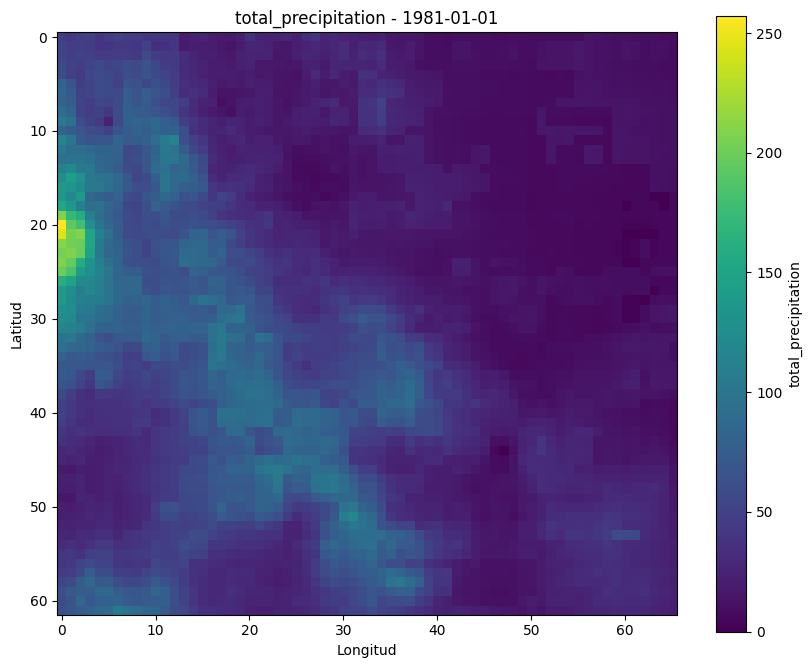

Estadísticas para total_precipitation:
  min: 0.0000
  max: 257.3568
  mean: 37.9301
  std: 29.9367


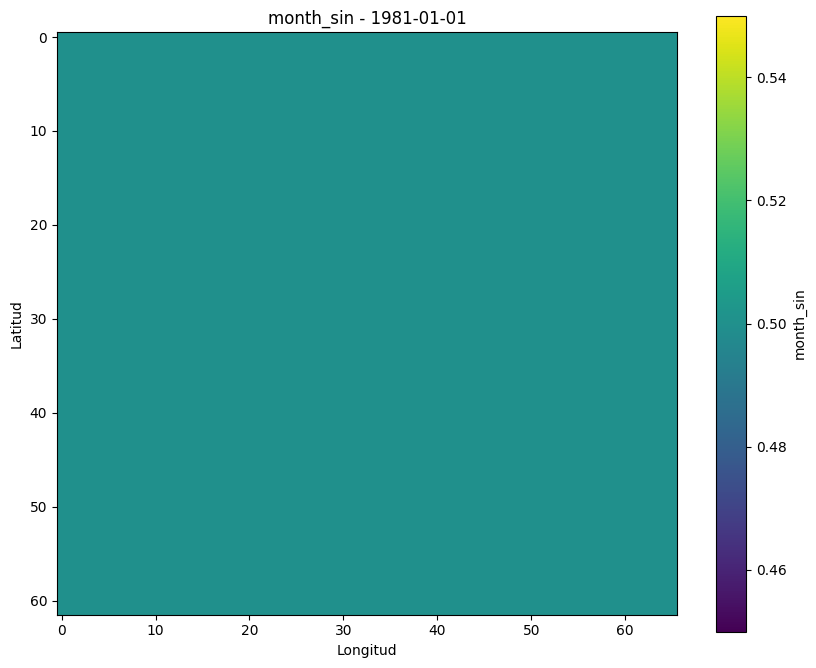

Estadísticas para month_sin:
  min: 0.5000
  max: 0.5000
  mean: 0.5000
  std: 0.0000


In [52]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

# ---------------------------------------------------------------
# Funciones auxiliares
# ---------------------------------------------------------------

def plot_variable(dataset, var_name, time_index=None):
    """Grafica una variable del dataset"""
    data = dataset[var_name]

    if 'time' in data.dims:
        if time_index is None:
            time_index = 0
        data = data.isel(time=time_index)

    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': var_name})
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_title(f"{var_name} ({'tiempo' if 'time' in dataset[var_name].dims else 'espacial'})")
    plt.show()

def describe_dataset(ds):
    """Genera estadísticas básicas del dataset"""
    print(f"\nResumen del dataset:")
    print(f"- Variables: {list(ds.data_vars)}")
    print(f"- Dimensiones: {dict(ds.dims)}")
    print(f"- Coordenadas: {list(ds.coords)}")

    # Coordenadas principales
    print(f"\nLatitudes: min={float(ds.latitude.min()):.4f}, max={float(ds.latitude.max()):.4f}, std={float(ds.latitude.std()):.4f}")
    print(f"Longitudes: min={float(ds.longitude.min()):.4f}, max={float(ds.longitude.max()):.4f}, std={float(ds.longitude.std()):.4f}")

    # Estadísticas de cada variable
    for var in ds.data_vars:
        data = ds[var].values
        if np.issubdtype(data.dtype, np.number):
            print(f"\n📈 Estadísticas de {var}:")
            print(f"  - Mínimo: {np.nanmin(data):.4f}")
            print(f"  - Máximo: {np.nanmax(data):.4f}")
            print(f"  - Media: {np.nanmean(data):.4f}")
            print(f"  - Desviación estándar: {np.nanstd(data):.4f}")

# ---------------------------------------------------------------
# Código principal
# ---------------------------------------------------------------

try:
    # Cargar el dataset
    dataset = xr.open_dataset(output_path)
    print(f"\n✅ Dataset cargado exitosamente.")

    describe_dataset(dataset)

    # Visualización general
    plot_variable(dataset, 'elevation')
    plot_variable(dataset, 'slope')
    plot_variable(dataset, 'aspect')

    # Variables de precipitación
    plot_variable(dataset, 'total_precipitation', time_index=0)
    plot_variable(dataset, 'max_daily_precipitation', time_index=0)
    plot_variable(dataset, 'min_daily_precipitation', time_index=0)
    plot_variable(dataset, 'daily_precipitation_std', time_index=0)

    # Variables de tiempo cíclico
    plot_variable(dataset, 'month_sin', time_index=0)
    plot_variable(dataset, 'month_cos', time_index=0)
    plot_variable(dataset, 'doy_sin', time_index=0)
    plot_variable(dataset, 'doy_cos', time_index=0)

except Exception as e:
    print(f"❌ Error cargando o procesando el dataset: {e}")


## Compartir el Dataset (Google Colab)

Si estás trabajando en Google Colab y deseas compartir o descargar el dataset, puedes usar el siguiente código:

In [53]:
# Código para compartir o descargar el dataset desde Google Colab
if IN_COLAB:
    try:
        from google.colab import files
        print(f"El dataset generado está disponible en: {output_path}")
        print("Para descargar el archivo, ejecuta la siguiente celda:")
    except Exception as e:
        print(f"Error al preparar descarga: {e}")

    # Esta celda descargará el archivo cuando se ejecute
    # files.download(output_path)
else:
    print("No estás en Google Colab, el dataset ya está guardado localmente en:")
    print(output_path)

El dataset generado está disponible en: /content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features.nc
Para descargar el archivo, ejecuta la siguiente celda:
